In [1]:
# Python ≥3.5 is required
import sys

import keras.datasets.mnist

print("Python: ", sys.version_info)
assert sys.version_info >= (3, 7)

# Scikit-Learn ≥0.20 is required
import sklearn
print("sklearn version: ", sklearn.__version__)
assert sklearn.__version__ >= "0.20"

try:
    # %tensorflow_version only exists in Colab.
    %tensorflow_version 2.x
except Exception:
    pass

try:
    # %tensorflow_version only exists in Colab.
    %tensorflow_version 2.x
    IS_COLAB = True
except Exception:
    IS_COLAB = False

# TensorFlow ≥2.8 is required
import tensorflow as tf
print("TF version: ", tf.__version__)
# assert tf.__version__ >= "2.8"

if not tf.config.list_physical_devices('GPU'):
    print("No GPU was detected. CNNs can be very slow without a GPU.")
    if IS_COLAB:
        print("Go to Runtime > Change runtime and select a GPU hardware accelerator.")

# GPU test
print("GPU installed: ",tf.test.is_built_with_gpu_support())

# To prevent "CUDNN_STATUS_ALLOC_FAILED" error with GPUs
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
  try:
    # Currently, memory growth needs to be the same across GPUs
    for gpu in gpus:
      tf.config.experimental.set_memory_growth(gpu, True)
    logical_gpus = tf.config.experimental.list_logical_devices('GPU')
    print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
  except RuntimeError as e:
    # Memory growth must be set before GPUs have been initialized
    print(e)

# Common imports
import numpy as np
import os
import pandas as pd
import tensorflow_datasets as tfds
from tensorflow_datasets.core.utils import gcs_utils
gcs_utils._is_gcs_disabled = True


# to make this notebook's output stable across runs
np.random.seed(42)

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# Where to save the figures
PROJECT_ROOT_DIR = "."
CHAPTER_ID = "ann"
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID)
os.makedirs(IMAGES_PATH, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

# Ignore useless warnings (see SciPy issue #5998)
import warnings
warnings.filterwarnings(action="ignore", message="^internal gelsd")

2024-05-12 00:13:07.485969: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-05-12 00:13:07.486018: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-05-12 00:13:07.486626: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-05-12 00:13:07.490463: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-05-12 00:13:08.029519: W tensorflow/compiler/tf2

Python:  sys.version_info(major=3, minor=9, micro=19, releaselevel='final', serial=0)
sklearn version:  1.4.1.post1
TF version:  2.15.0
GPU installed:  True
1 Physical GPUs, 1 Logical GPUs


2024-05-12 00:13:09.110542: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-05-12 00:13:09.129352: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-05-12 00:13:09.129402: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-05-12 00:13:09.131770: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-05-12 00:13:09.131811: I external/local_xla/xla/stream_executor

In [2]:
from pathlib import Path

IMAGES_PATH = Path() / "images" / "deep"
IMAGES_PATH.mkdir(parents=True, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = IMAGES_PATH / f"{fig_id}.{fig_extension}"
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

In [3]:
DATA_PATH = Path() / "datasets" / "emnist"
DATA_PATH.mkdir(parents=True, exist_ok=True)

### get the data(EMNIST)

In [4]:
! pip install --upgrade tfds-nightly

/bin/bash: warning: setlocale: LC_ALL: cannot change locale (en_US.UTF-8)


In [92]:
import tensorflow_datasets as tfds

# try:
#     tem = tfds.image_classification.EMNIST()
#     tem.download_and_prepare()
# except:
#     class EMNIST(tfds.image_classification.EMNIST):
#         URL = "https://biometrics.nist.gov/cs_links/EMNIST/gzip.zip"
#         
#     tem = EMNIST()
#     tem.download_and_prepare()

nameList = ["balanced",
            "byclass",
            "bymerge",
            "digits",
            "letters",
            "mnist"]

# datasets name list
# 0 - balanced
# 1 - byclass
# 2 - bymerge
# 3 - digits
# 4 - letters
# 5 - mnist
# 
# do not use 3~5, this only includes part of EMNIST
dtype = 1

# default - byclass
(train_bal, test_bal), info_bal = tfds.load("emnist" + "/" + nameList[0], split=['train','test'], as_supervised=True, with_info=True)
(train_class, test_class), info_class = tfds.load("emnist" + "/" + nameList[1], split=['train','test'], as_supervised=True, with_info=True)
(train_merge, test_merge), info_merge = tfds.load("emnist" + "/" + nameList[2], split=['train','test'], as_supervised=True, with_info=True)


현재(2024-05-06) 작동하지 않음 - https://www.itl.nist.gov/iaui/vip/cs_links/EMNIST/gzip.zip 해당 사이트로 renewal 된 것을 아직 번영하지 않음
> 고침! 새 link로 상속시키면 됨
> 
2024-05-09 - tfds 쪽 URL가 고쳐져서 정상적으로 쓰면 됨

최초로 사용하는 datasets들은 처음에 다운로드하는 데 시간이 걸림. 그 후는 이미 존재하는 내용을 사용해서 바로 됨

In [6]:
# deprecated code

# if not os.path.isfile(dpath / "archive.zip"):
#     import requests
#     
#     url = "https://biometrics.nist.gov/cs_links/EMNIST/gzip.zip"
#     response = requests.get(url)
#     
#     with open(dpath / "archive.zip", mode="wb") as file:
#         file.write(response.content)

[cannot load..](https://github.com/tensorflow/datasets/issues/5356)

In [7]:
# deprecated code

# print(dpath)
# 
# import zipfile
# arc = zipfile.ZipFile(dpath / 'archive.zip','r')
# 
# nameList = ["emnist-balanced",
#             "emnist-byclass",
#             "emnist-bymerge",
#             "emnist-digits",
#             "emnist-letters",
#             "emnist-mnist"]
# 
# # datasets name list
# # 0 - balanced
# # 1 - byclass
# # 2 - bymerge
# # 3 - digits
# # 4 - letters
# # 5 - mnist
# 
# dtype = 0
# 
# train_bal = pd.read_csv(arc.open(nameList[dtype] + "-train.csv"))
# test_bal = pd.read_csv(arc.open(nameList[dtype] + "-test.csv"))

In [8]:
# train_bal = pd.DataFrame()
# 
# for cnt, chunk in enumerate(pd.read_csv(dpath / "emnist-byclass-train.csv",chunksize=10000)):
#     train_bal = pd.concat([train_bal, chunk])


In [93]:
print(info_bal)

tfds.core.DatasetInfo(
    name='emnist',
    full_name='emnist/balanced/3.0.0',
    description="""
    The EMNIST dataset is a set of handwritten character digits derived from the NIST Special Database 19 and converted to a 28x28 pixel image format and dataset structure that directly matches the MNIST dataset.
    
    Note: Like the original EMNIST data, images provided here are inverted horizontally and rotated 90 anti-clockwise. You can use `tf.transpose` within `ds.map` to convert the images to a human-friendlier format.
    """,
    config_description="""
    EMNIST Balanced
    """,
    homepage='https://www.nist.gov/itl/products-and-services/emnist-dataset',
    data_dir='/home/choi-wsl/tensorflow_datasets/emnist/balanced/3.0.0',
    file_format=tfrecord,
    download_size=Unknown size,
    dataset_size=56.63 MiB,
    features=FeaturesDict({
        'image': Image(shape=(28, 28, 1), dtype=uint8),
        'label': ClassLabel(shape=(), dtype=int64, num_classes=47),
    }),
    s

In [94]:
info_bal.features

FeaturesDict({
    'image': Image(shape=(28, 28, 1), dtype=uint8),
    'label': ClassLabel(shape=(), dtype=int64, num_classes=47),
})

In [95]:
train_size = info_bal.splits['train'].num_examples
test_size = info_bal.splits['test'].num_examples
print(f'train_size: {train_size} 개\ntest_size: {test_size} 개')

train_size: 112800 개
test_size: 18800 개


In [96]:
# or
tfds.as_dataframe(train_bal.take(4), info_bal)

2024-05-12 01:00:45.466866: W tensorflow/core/kernels/data/cache_dataset_ops.cc:858] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


,image,label
0,,31
1,,35
2,,30
3,,7


In [13]:
# deprecated code

# num_columns = 785
# 
# # Create column names
# columns = ['label'] + list(range(1, num_columns))
# 
# # Assign column names to the DataFrames
# train_bal.columns = columns
# test_bal.columns = columns
# 
# # Reset index
# train_bal = train_bal.reset_index(drop=True)
# test_bal = test_bal.reset_index(drop=True)
# 
# # Extract features and labels
# x_train = train_bal.drop(['label'], axis=1)
# y_train = train_bal['label']
# x_test = test_bal.drop(['label'], axis=1)
# y_test = test_bal['label']
# 
# # Display the first few rows of the DataFrame
# print(train_bal.head())
# print(test_bal.head())

In [14]:
# train_bal["label"].value_counts()

In [97]:
tfds.benchmark(train_bal, batch_size=32)


************ Summary ************


  0%|          | 0/112800 [00:00<?, ?it/s]

Examples/sec (First included) 286854.64 ex/sec (total: 3609632 ex, 12.58 sec)
Examples/sec (First only) 1088.23 ex/sec (total: 32 ex, 0.03 sec)
Examples/sec (First excluded) 287524.00 ex/sec (total: 3609600 ex, 12.55 sec)


,duration,num_examples,avg
first+lasts,12.583488,3609632,286854.641692
first,0.029406,32,1088.228722
lasts,12.554083,3609600,287523.995896


In [98]:
print(info_bal.features["label"].num_classes)
print(info_bal.features["label"].names)

47
['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12', '13', '14', '15', '16', '17', '18', '19', '20', '21', '22', '23', '24', '25', '26', '27', '28', '29', '30', '31', '32', '33', '34', '35', '36', '37', '38', '39', '40', '41', '42', '43', '44', '45', '46']


## labeling

In [99]:
def getClasses(type):
    file = open("datasets/emnist/emnist-" + nameList[type] +"-mapping.txt",'r')
    lines = file.readlines()
    
    classes = []
    
    for line in lines:
        classes.append(chr(int(line.split()[-1])))
    
    file.close()
    
    return classes

In [102]:
classes_bal = getClasses(0)
classes_class = getClasses(1)
classes_merge = getClasses(2)

In [104]:
print(classes_bal)
print(classes_class)
print(classes_merge)

['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', 'A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z', 'a', 'b', 'd', 'e', 'f', 'g', 'h', 'n', 'q', 'r', 't']
['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', 'A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z']
['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', 'A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z', 'a', 'b', 'd', 'e', 'f', 'g', 'h', 'n', 'q', 'r', 't']


each label - [link](https://www.kaggle.com/code/ashenonebot1/handwritten-digits-letters-classification)

## visualization

simple example using `tfds.show_examples()`

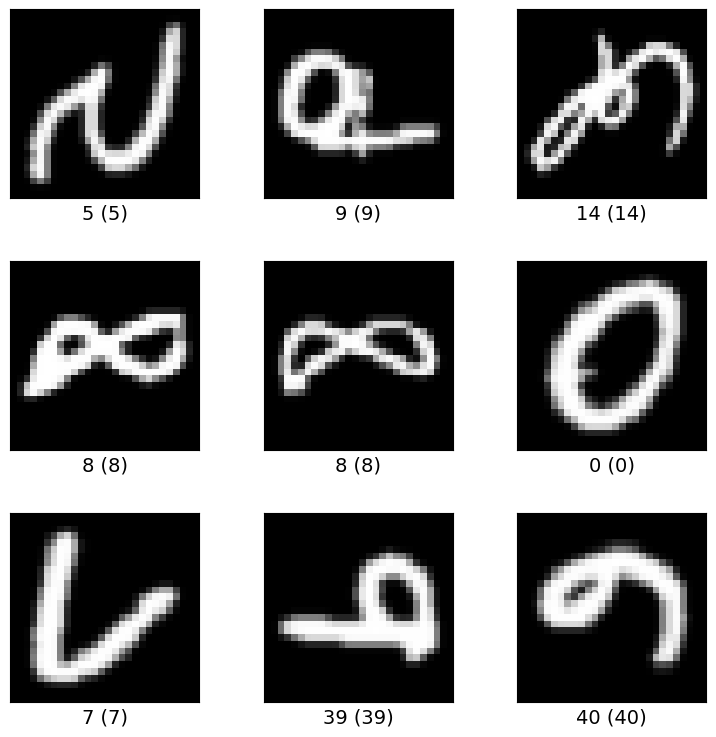

In [105]:
fig = tfds.show_examples(train, info)

문제점:
> 1. label이 integer로 되어있음. 학습하는 동안은 이게 맞지만 사람이 직접 확인할 때는 문제가 생김(머가 먼지 모름)
> 2. 이미지가 90도 돌아가 있음. 이거는 `transpose()`로 간단히 해결할 수는 있음(아마도...)

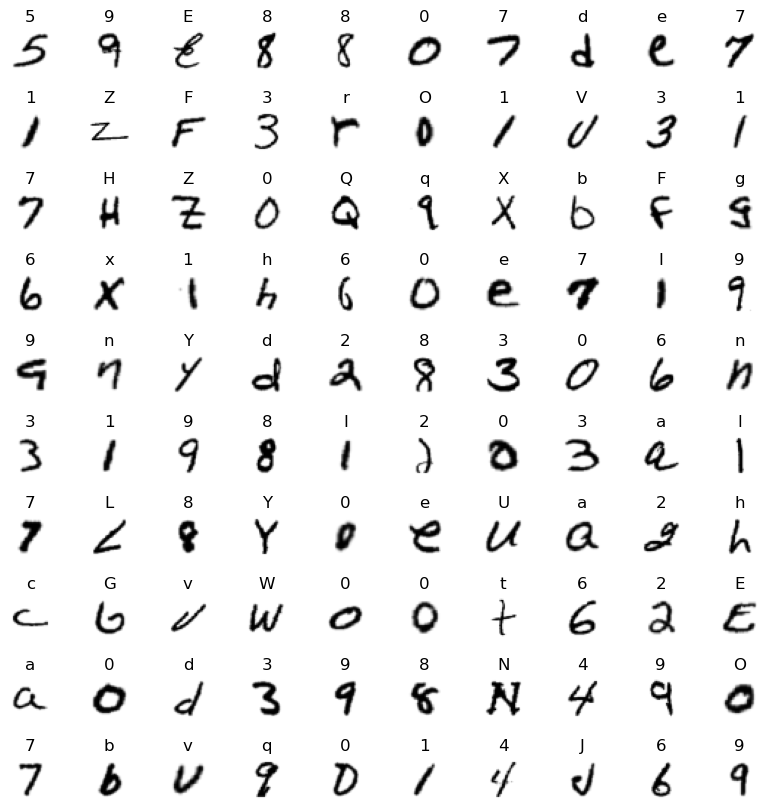

In [130]:
cnt = 0

# this enables to treat tensors like numpy
tf.experimental.numpy.experimental_enable_numpy_behavior()

import matplotlib.cm as cm

train_sub = train.take(100)

plt.figure(figsize=(10,10))
plt.subplots_adjust(hspace=1)
i = 0
for images, labels in train_sub:
    ax = plt.subplot(10,10,i+1)
    plt.imshow(images.reshape((28,28)).transpose(), cmap="binary")
    plt.title(classes[labels.numpy()])
    plt.axis("off")
    i = i + 1

In [110]:
cnt_bal = np.array([label for image, label in train_bal])
cnt_class = np.array([label for image, label in train_class])
cnt_merge = np.array([label for image, label in train_merge])

In [111]:
tes_bal = np.array(classes_bal)[cnt_bal]
tes_class = np.array(classes_class)[cnt_class]
tes_merge = np.array(classes_merge)[cnt_merge]

In [113]:
class_labels_bal, class_counts_bal = np.unique(tes_bal, return_counts=True)
class_labels_class, class_counts_class = np.unique(tes_class, return_counts=True)
class_labels_merge, class_counts_merge = np.unique(tes_merge, return_counts=True)


In [126]:
def plotEMNIST(class_labels, class_counts, title):
    # plt.figure(figsize=(8, 10))
    plt.barh(class_labels, class_counts)
    plt.xlabel('Number of Samples')
    plt.ylabel('Class Label')
    plt.xlim(0,42000)
    plt.title(title)
    for i, v in enumerate(class_counts):
        plt.text(v + 3, i, str(v), fontweight='bold',size='small')
    plt.grid(axis='x')
    plt.tight_layout()

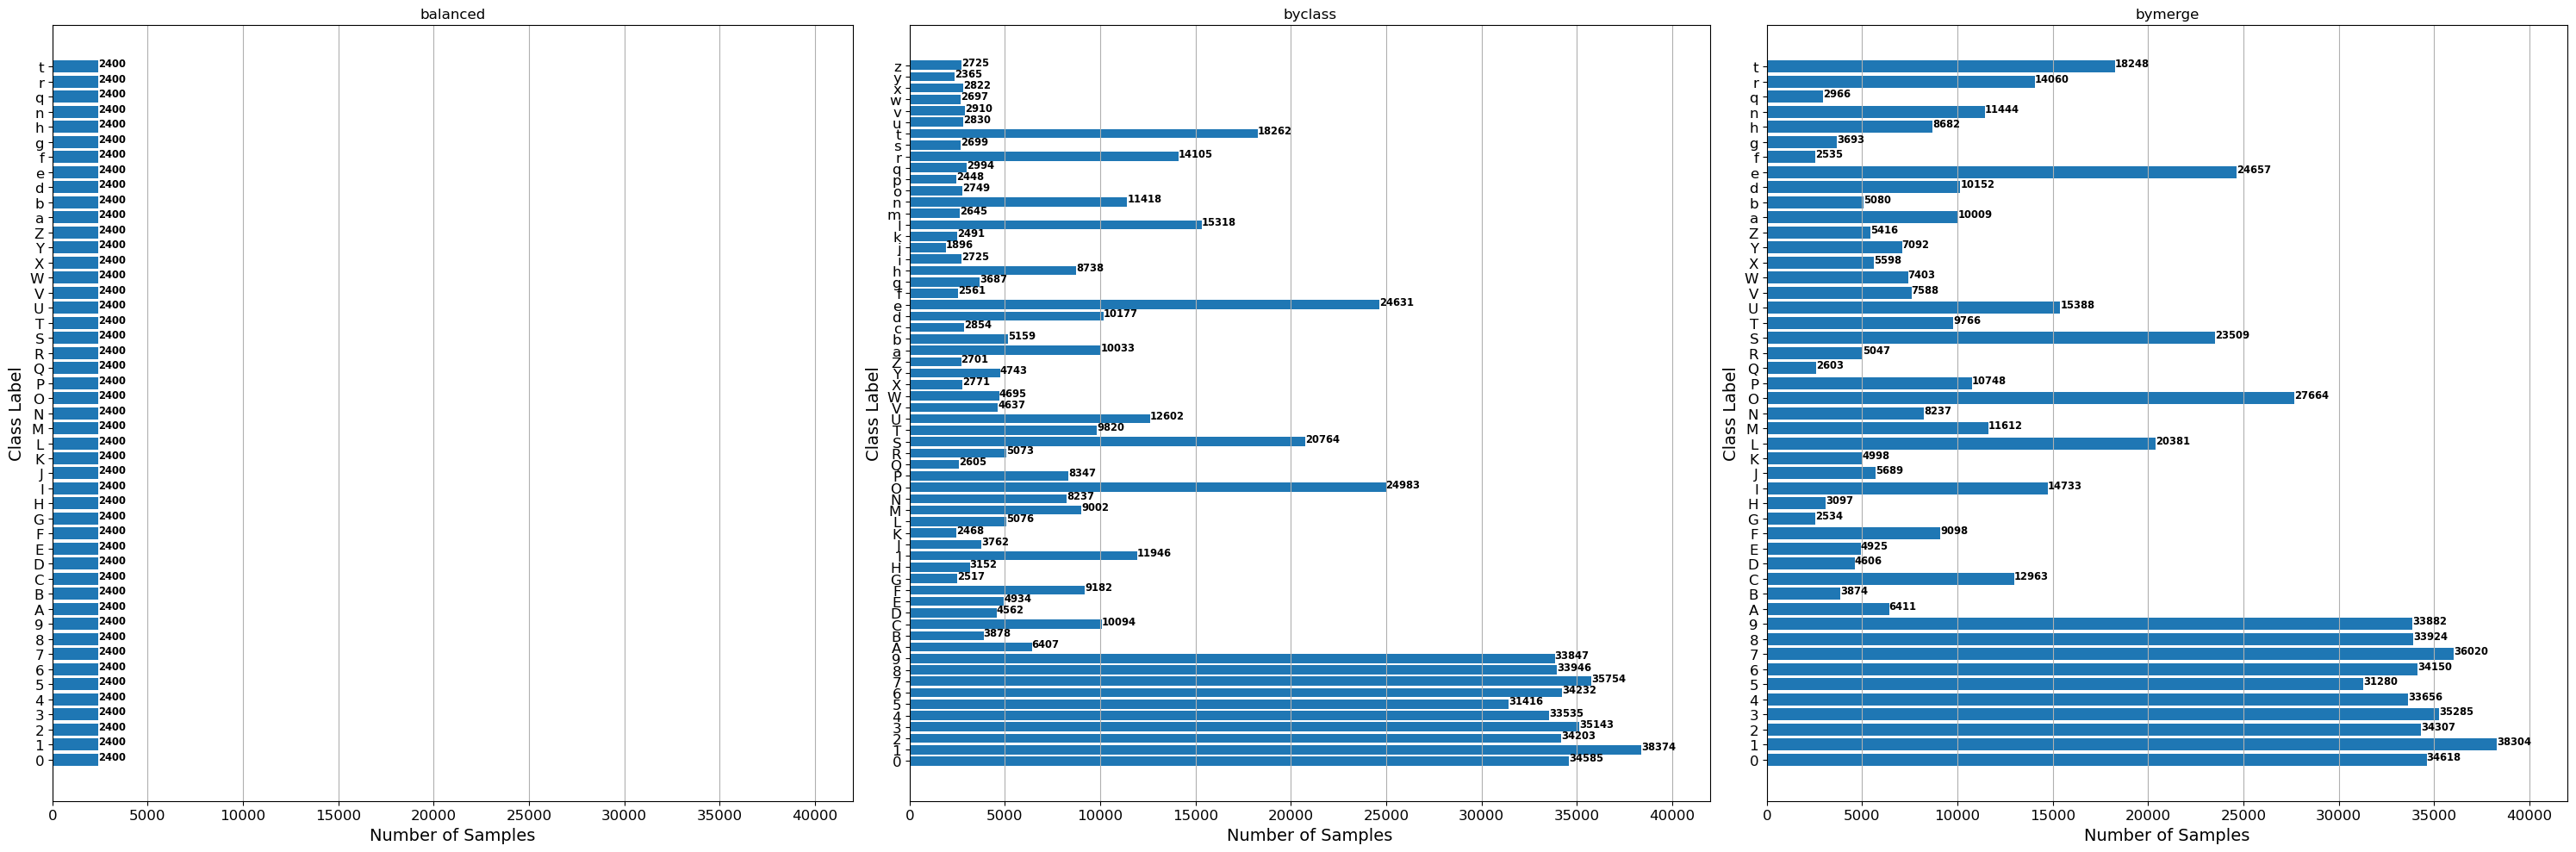

In [127]:
fig = plt.figure(figsize=(30,10))
plt.subplot(1,3,1)
plotEMNIST(class_labels_bal,class_counts_bal, "balanced")
plt.subplot(1,3,2)
plotEMNIST(class_labels_class, class_counts_class, "byclass")
plt.subplot(1,3,3)
plotEMNIST(class_labels_merge, class_counts_merge, "bymerge")
plt.show()

bymerge, balanced 에는 일부(c,i,j,k,l,m,o,p,s,u,v,w,x,y,z) 가 존재하지 않음

### todo - class 비교 및 각 label 동일

In [22]:
# import matplotlib.pyplot as plt
# 
# def plot(image_data, label="nan"):
#     image = image_data.reshape(28, 28)
#     plt.imshow(image.transpose(), cmap="binary")
#     plt.axis("off")
#     plt.title(label)
# 
# def plot_multi(image_data, labels, row = 10, col = 10):
#     plt.figure(figsize=(row-1,col-1))
#     for idx, image in enumerate(image_data[:row*col]):
#         plt.subplot(row, col, idx + 1)
#         plot(image,label_bal[labels[idx]])
#     # plt.subplots_adjust(wspace=0, hspace=0)
#     plt.show()

In [131]:
# plot(x_train[0])

In [132]:
# plot_multi(x_train,y_train)

## train(beta)

[link](https://www.kaggle.com/code/akankshajo/emnist-letter-dataset-97-9-acc-val-acc-91-78)
[and link](https://www.kaggle.com/code/ashenonebot1/handwritten-digits-letters-classification)

In [133]:
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

label_size = len(label_bal)

class Reshaper(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self

    def transform(self, X):
        X_reshaped = X.reshape(-1, 28, 28, 1)
        return X_reshaped

# Define the pipeline
pipeline = Pipeline([
    ('scaler', StandardScaler()),  # Step 1: StandardScaler
    ('reshaper', Reshaper())  # Step 2: Custom Reshaper
])


# Fit and transform the training data

x_train_processed = pipeline.fit_transform(x_train / 255.)
y_train_processed = np.eye(label_size)[y_train.astype(int)]

x_test_processed = pipeline.transform(x_test / 255.)

y_test_processed = np.eye(label_size)[y_test.astype(int)]

NameError: name 'label_bal' is not defined

In [118]:
print('input shape',x_train_processed.shape)
print('output shape',y_train.shape)
# y_train = np.eye(62)[y_train.astype(int)]
print('output shape',y_train_processed.shape)

input shape (112799, 28, 28, 1)
output shape (112799,)
output shape (112799, 47)


In [119]:
from keras.models import Sequential
from keras.layers import Dense, Flatten, Conv2D, MaxPooling2D,Dropout

#  multiple model architectures
models = []
input_shape=(28,28,1)
output = 47

# Model 1
model1 = Sequential()
model1.add(Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=input_shape))
model1.add(MaxPooling2D((2, 2)))
model1.add(Flatten())
model1.add(Dense(128, activation='relu'))
model1.add(Dense(output, activation='softmax'))
models.append(model1)

# Model 2
model2 = Sequential()
model2.add(Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=input_shape))
model2.add(Dropout(0.25)) 
model2.add(MaxPooling2D((2, 2)))
model2.add(Flatten())
model2.add(Dense(128, activation='relu'))
model2.add(Dropout(0.4))
model2.add(Dense(output, activation='softmax'))
# Add layers for Model 2
models.append(model2)

# Model 3
model3 = Sequential()
model3.add(Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=input_shape))
model3.add(Dropout(0.25)) 
model3.add(MaxPooling2D((2, 2)))
model3.add(Flatten())
model3.add(Dense(256, activation='relu'))
model3.add(Dropout(0.4))
model3.add(Dense(128, activation='relu'))
model3.add(Dense(output, activation='softmax'))
models.append(model3)

# Train each model
for i, model in enumerate(models):
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    model.fit(x_train_processed, y_train_processed, epochs=5, batch_size=32)

# Evaluate each model
accuracies = []
for i, model in enumerate(models):
    loss, accuracy = model.evaluate(x_test_processed, y_test_processed)
    accuracies.append(accuracy)
    print(f"Model {i+1} Accuracy: {accuracy}")

# Select the best model based on accuracy
best_model_index = accuracies.index(max(accuracies))
best_model = models[best_model_index]
print(f"Best Model: Model {best_model_index+1}")

Epoch 1/5
3525/3525 [==============================] - 24s 6ms/step - loss: 0.7625 - accuracy: 0.7669
Epoch 2/5
3525/3525 [==============================] - 20s 6ms/step - loss: 0.4645 - accuracy: 0.8461
Epoch 3/5
3525/3525 [==============================] - 20s 6ms/step - loss: 0.3992 - accuracy: 0.8619
Epoch 4/5
3525/3525 [==============================] - 20s 6ms/step - loss: 0.3552 - accuracy: 0.8743
Epoch 5/5
3525/3525 [==============================] - 20s 6ms/step - loss: 0.3276 - accuracy: 0.8822
Epoch 1/5


2024-05-01 08:44:54.584418: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential_7/dropout_8/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


3525/3525 [==============================] - 22s 6ms/step - loss: 1.1672 - accuracy: 0.6503
Epoch 2/5
3525/3525 [==============================] - 22s 6ms/step - loss: 0.7558 - accuracy: 0.7592
Epoch 3/5
3525/3525 [==============================] - 22s 6ms/step - loss: 0.6799 - accuracy: 0.7808
Epoch 4/5
3525/3525 [==============================] - 22s 6ms/step - loss: 0.6374 - accuracy: 0.7935
Epoch 5/5
3525/3525 [==============================] - 22s 6ms/step - loss: 0.6006 - accuracy: 0.8023
Epoch 1/5


2024-05-01 08:46:45.289714: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential_8/dropout_10/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


3525/3525 [==============================] - 23s 6ms/step - loss: 1.0123 - accuracy: 0.6889
Epoch 2/5
3525/3525 [==============================] - 23s 7ms/step - loss: 0.6569 - accuracy: 0.7847
Epoch 3/5
3525/3525 [==============================] - 23s 7ms/step - loss: 0.5814 - accuracy: 0.8059
Epoch 4/5
3525/3525 [==============================] - 23s 6ms/step - loss: 0.5384 - accuracy: 0.8180
Epoch 5/5
588/588 [==============================] - 3s 5ms/step - loss: 0.4967 - accuracy: 0.8497
Model 1 Accuracy: 0.8496728539466858
588/588 [==============================] - 3s 6ms/step - loss: 0.4916 - accuracy: 0.8423
Model 2 Accuracy: 0.8423320651054382
588/588 [==============================] - 3s 5ms/step - loss: 0.4312 - accuracy: 0.8528
Model 3 Accuracy: 0.852811336517334
Best Model: Model 3


In [120]:
a = 1
